# EDA

## Описание задачи

Необходимо обучить три классификатора на основе TF-IDF, FastText и BERT и выбрать тот, который наилучшим образом выполняет задачу классификации. Для обучения и анализа работы дан датасет состоящий из более чем пяти тысяч SMS сообщений. Данные представлены в виде двух столбцов. В первом столбце указано одно из двух значений класса: "ham" или "spam", что означает обычное сообщение и спам соответственно. В втором столбце приведен текст сообщения в одну строку.

## Загрузка и первичный анализ

### Загрузка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'text'])

print(df.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### Проверка структуры и пропусков

In [3]:
print("\nОбщая информация о датасете:")
print(df.info())

print("\nПроверка на пропуски:")
print(df.isnull().sum())


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Проверка на пропуски:
label    0
text     0
dtype: int64


### Анализ баланса классов


Распределение классов:
       Количество  Процент (%)
label                         
ham          4825    86.593683
spam          747    13.406317


/tmp/ipykernel_7298/896692324.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


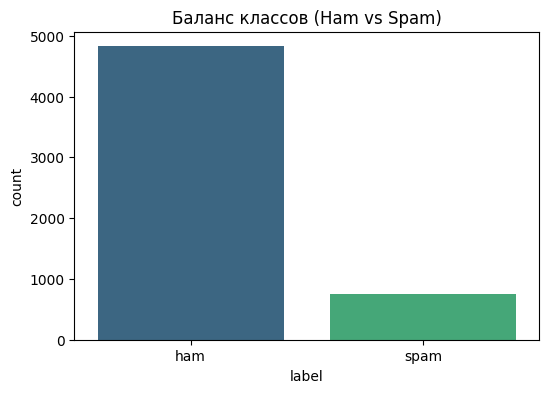

In [4]:
label_counts = df['label'].value_counts()
label_perc = df['label'].value_counts(normalize=True) * 100

print("\nРаспределение классов:")
print(pd.DataFrame({'Количество': label_counts, 'Процент (%)': label_perc}))

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Баланс классов (Ham vs Spam)')
plt.show()

### Анализ характеристик текста


Статистика длины сообщений:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0


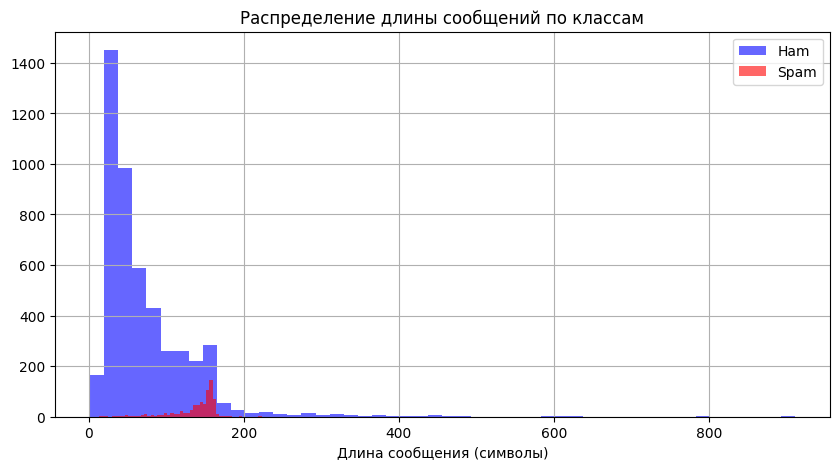

In [5]:
df['length'] = df['text'].apply(len)

print("\nСтатистика длины сообщений:")
print(df.groupby('label')['length'].describe())

plt.figure(figsize=(10, 5))
df[df['label'] == 'ham']['length'].hist(bins=50, color='blue', label='Ham', alpha=0.6)
df[df['label'] == 'spam']['length'].hist(bins=50, color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel('Длина сообщения (символы)')
plt.title('Распределение длины сообщений по классам')
plt.show()

### Итоги предварительного анализа
    - По итогам проверки не было зафиксировано ни одного пропуска.
    - Выявлен существенный дисбаланс классов: 86.6% для категории "ham" и 13.4% для категории "spam".
    - Анализ длины сообщения показал, что для сообщений из категории "ham" более характерна много меньшая длина (в среднем это 71.5 символа), когда для сообщений из "spam" средний показатель выше: 138.5 символа. Такое отличие является важным признаком, помогающим модели принять решение в пользу того или иного класса.

## Препроцессинг данных

### Кодирование целевой переменной и очистка текста

In [6]:
import re
import nltk
from nltk.corpus import stopwords

df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)

    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

# Создаем новый столбец с чистым текстом
df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/valwork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Анализ частоты слов

In [7]:
from collections import Counter

def get_top_words(texts, n=10):
    all_words = " ".join(texts).split()
    return Counter(all_words).most_common(n)

print("Топ-10 слов в ham:")
print(get_top_words(df[df['label_num'] == 0]['clean_text']))

print("\nТоп-10 слов в spam:")
print(get_top_words(df[df['label_num'] == 1]['clean_text']))

Топ-10 слов в ham:
[('u', 1001), ('im', 463), ('get', 307), ('dont', 276), ('ltgt', 276), ('ok', 273), ('go', 252), ('ur', 246), ('ill', 242), ('got', 233)]

Топ-10 слов в spam:
[('call', 350), ('free', 219), ('u', 155), ('txt', 151), ('ur', 144), ('mobile', 124), ('text', 121), ('stop', 118), ('claim', 113), ('reply', 101)]


### Результаты препроцессинга
Вывод наиболее частых слов в каждой из категорий показал, что в "ham" преобладают слова, часто употребляемые в быту (u, im, get, dont и т. д.), а в "spam" используемые в рекламе, побуждающие слова (call, free, mobile, text). 
Очищенный текст сообщений необходим для TF-IDF и FastText, тогда как для обучения BERT нужно использовать "сырой" текст, потому что BERT может учитывать контекст, в котором употребляются стоп-слова и знаки препинания.

## Разделение данных на обучающую и тестовую выборки

In [8]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

# необработанные данные для BERT
X_train_raw, X_test_raw, _, _ = train_test_split(
    df['text'], 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Размер обучающей выборки: {len(X_train)} строк")
print(f"Размер тестовой выборки: {len(X_test)} строк")

print("\nДоля спама в исходных данных:")
print(df['label_num'].value_counts(normalize=True)[1])

print("\nДоля спама в обучающей выборке:")
print(y_train.value_counts(normalize=True)[1])

print("\nДоля спама в тестовой выборке:")
print(y_test.value_counts(normalize=True)[1])

Размер обучающей выборки: 4457 строк
Размер тестовой выборки: 1115 строк

Доля спама в исходных данных:
0.13406317300789664

Доля спама в обучающей выборке:
0.13417096701817366

Доля спама в тестовой выборке:
0.1336322869955157


### Результаты разбиения данных

Данные в обоих группах (обработанные и "сырые") были разделены на обучающую и тестовую выборки с сохранением изначальной пропорции: 13.4% для спама и 86.6% для нормальных сообщений. Для этого при разбиении использовался метод стратификации.

# Обучение моделей

## Обучение base-line модели (TF-IDF + Logistic Regression)

В качестве модели, с результатами работы которой будет сравниваться точность более сложных моделей, была выбрана модель линейной регрессии в сочетании с методом векторизации TF-IDF

Затрачено времени: 0.0005 секунд
Веса топ-10 слов-признаков спама:
win: 2.8651
service: 2.8767
call: 3.0870
reply: 3.2471
text: 3.2487
free: 3.2724
mobile: 3.3086
stop: 3.7421
claim: 3.7457
txt: 4.9376
Отчет о классификации:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115

ROC-AUC score: 0.9853


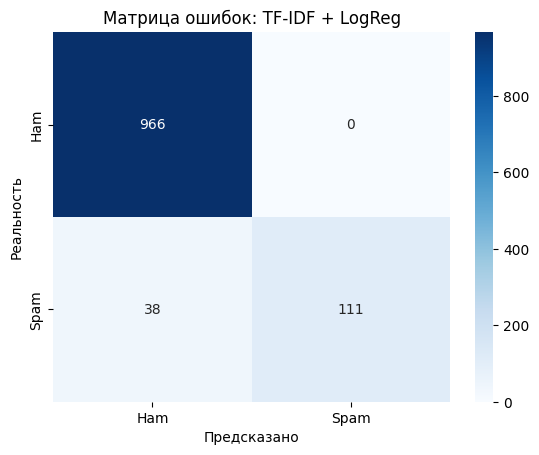

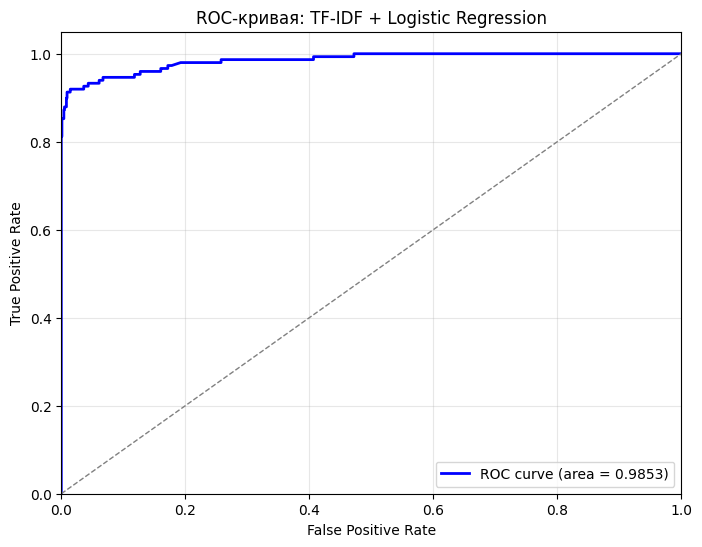

In [11]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np

vectorizer = TfidfVectorizer(max_features=5000) 
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_tfidf, y_train)

start_time = time.time()

y_pred_lr = lr_model.predict(X_test_tfidf)
y_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

end_time = time.time()
print(f"Затрачено времени: {end_time - start_time:.4f} секунд")

feature_names = vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

top_spam_indices = np.argsort(coefficients)[-10:]
print("Веса топ-10 слов-признаков спама:")
for i in top_spam_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("Отчет о классификации:")
print(classification_report(y_test, y_pred_lr, target_names=['Ham', 'Spam']))
print(f"ROC-AUC score: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Предсказано')
plt.ylabel('Реальность')
plt.title('Матрица ошибок: TF-IDF + LogReg')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая: TF-IDF + Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Анализ работы base-line модели

Модель обучается очень быстро, ее обучение занимает 0.0005 секунды, то есть она нетребовательна к ресурсам машины. Также комбинация TF-IDF и LogReg дает отличную точность предсказания: отсутсвие ложноположительных результатов и высокий показатель ROC-AUC (0.98). Для базовой модели это довольно высокая планка. Также тот факт, что модель присвоила высокие веса словам вроде txt, claim, stop, mobile, free, говорит об адекватности модели.

## Обучение FastText

Read 0M words
Number of words:  7430
Number of labels: 2
Progress:  71.3% words/sec/thread: 1225783 lr:  0.143679 avg.loss:  0.012616 ETA:   0h 0m 0s

Затрачено времени: 0.0272 секунд
Финальный отчет FastText:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

ROC-AUC Score: 0.9835


Progress: 100.0% words/sec/thread:  860998 lr:  0.000000 avg.loss:  0.009494 ETA:   0h 0m 0s


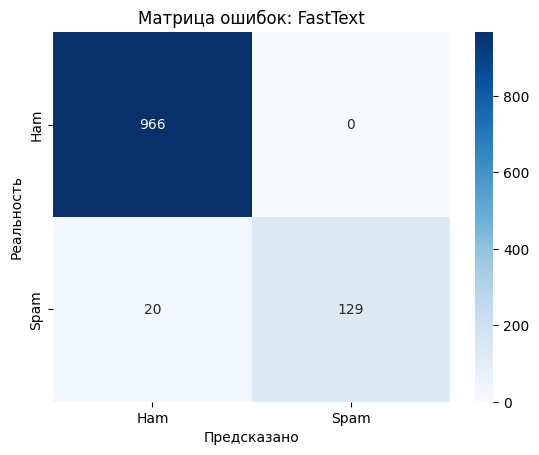

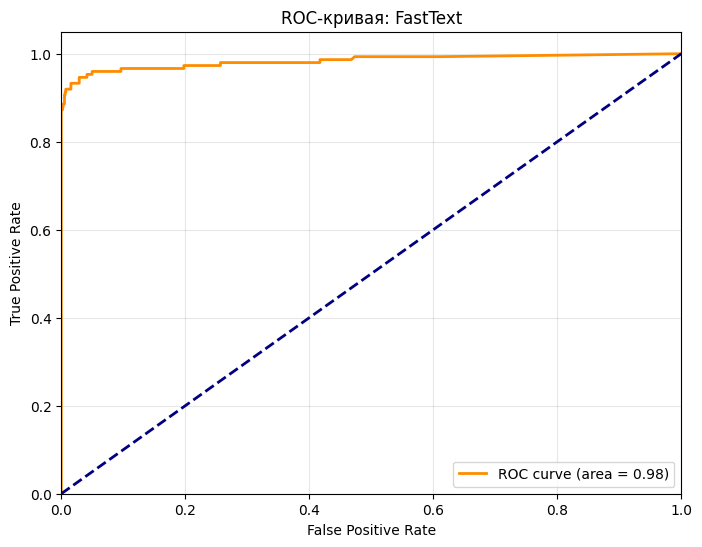

In [10]:
import fasttext
def prepare_ft_file(X, y, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for text, label in zip(X, y):
            f.write(f'__label__{label} {text}\n')

prepare_ft_file(X_train, y_train, 'train_ft.txt')
prepare_ft_file(X_test, y_test, 'test_ft.txt')

ft_model = fasttext.train_supervised(
    input='train_ft.txt', 
    lr=0.5, 
    epoch=25, 
    wordNgrams=2, 
    bucket=200000, 
    dim=100, 
    loss='softmax'
)

# вероятности для тестовой выборки
y_prob_ft = []
y_pred_ft = []

start_time = time.time()

for text in X_test:
    labels, probabilities = ft_model.predict(text.replace('\n', ' '))

    pred_label = int(labels[0].replace('__label__', ''))
    y_pred_ft.append(pred_label)

    if labels[0] == '__label__1':
        y_prob_ft.append(probabilities[0])
    else:
        y_prob_ft.append(1 - probabilities[0])

end_time = time.time()
print(f"Затрачено времени: {end_time - start_time:.4f} секунд")

fpr, tpr, thresholds = roc_curve(y_test, y_prob_ft)
roc_auc = auc(fpr, tpr)

print("Финальный отчет FastText:")
print(classification_report(y_test, y_pred_ft, target_names=['Ham', 'Spam']))
print(f"ROC-AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_ft)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Предсказано')
plt.ylabel('Реальность')
plt.title('Матрица ошибок: FastText')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая: FastText')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Обучение BERT

Учитывая аппаратные ограничения, вместо BERT целесообразно выбрать DistilBERT

### Подготовка данных

In [50]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# данные в формате Hugging Face Dataset
train_ds = Dataset.from_pandas(pd.DataFrame({'text': X_train_raw, 'label': y_train}))
test_ds = Dataset.from_pandas(pd.DataFrame({'text': X_test_raw, 'label': y_test}))

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_test = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

### Обучение

In [88]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

start_time = time.time()

trainer.train()

end_time = time.time()
print(f"Затрачено времени: {end_time - start_time:.2f} секунд")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.043593
2,0.057300,0.045812
3,0.057300,0.046627
4,0.005700,0.056785
5,0.005700,0.052127
6,0.001200,0.055498
7,0.001200,0.057075
8,0.000100,0.058169
9,0.000100,0.058757
10,0.000100,0.059026


Затрачено времени: 1338.39 секунд


### Анализ результатов


Финальный отчет BERT:
              precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       966
        Spam       0.98      0.96      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115

BERT ROC-AUC score: 0.9956


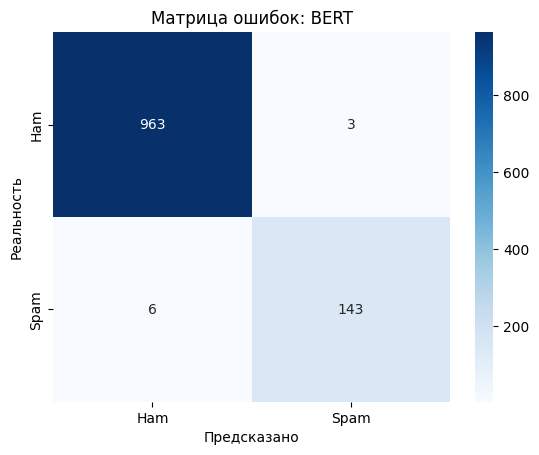

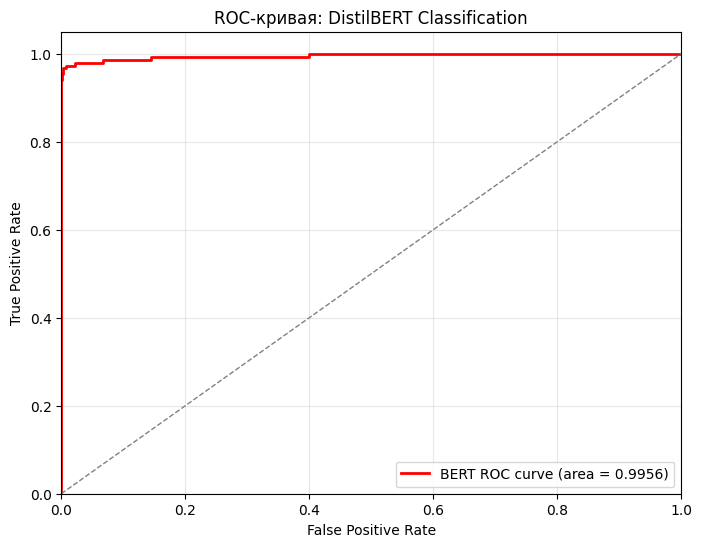

In [91]:
import torch.nn.functional as F

output = trainer.predict(tokenized_test)
logits = torch.from_numpy(output.predictions)

probs = F.softmax(logits, dim=-1)

y_prob_bert = probs[:, 1].numpy()
y_pred_bert = torch.argmax(probs, dim=-1).numpy()

fpr, tpr, thresholds = roc_curve(y_test, y_prob_bert)
roc_auc_bert = auc(fpr, tpr)

print("\nФинальный отчет BERT:")
print(classification_report(y_test, y_pred_bert, target_names=['Ham', 'Spam']))

print(f"BERT ROC-AUC score: {roc_auc_bert:.4f}")

cm = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Предсказано')
plt.ylabel('Реальность')
plt.title('Матрица ошибок: BERT')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'BERT ROC curve (area = {roc_auc_bert:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая: DistilBERT Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Анализ ошибок

In [92]:
def get_errors(model, tokenizer, dataset, device):
    model.eval()
    errors = []
    
    print("Анализ ошибок...")
    for item in dataset:
        # Подготовка текста
#        inputs = tokenizer(item["text"], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        inputs = tokenizer(item["text"], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Получаем вероятности через Softmax
            probs = F.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(probs, dim=-1).item()
            conf = probs[0][prediction].item()
        
        # Если модель ошиблась (False Negative: метка 1, а предсказано 0)
        if item["label"] == 0 and prediction == 1:
            errors.append({
                "Text": item["text"][:150] + "...", # Берем начало текста
                "True Label": item["label"],
                "Prediction": prediction,
                "Confidence": f"{conf:.4f}"
            })
            
    return pd.DataFrame(errors)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Запуск анализа (используем ваш тестовый датасет)
df_errors = get_errors(model, tokenizer, tokenized_test, device)

# Вывод 5 ошибок
print(f"\nНайдено False Positive ошибок: {len(df_errors)}")
print(df_errors.head(10))

Анализ ошибок...

Найдено False Positive ошибок: 3
                                                Text  True Label  Prediction  \
0  MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...           0           1   
1  We are pleased to inform that your application...           0           1   
2  staff.science.nus.edu.sg/~phyhcmk/teaching/pc1...           0           1   

  Confidence  
0     0.5202  
1     0.9960  
2     0.9998  


BERT выдала довольно высокие показатели метрик — выше, чем остальные модели. Но матрица ошибок показала наличие ложноположительных оценок. Увеличение количества эпох дало лишь незначительное уменьшение таких оценок. Это может быть связано с тем, что модель учитывает смысл текста и не может отличить нормальное сообщение от спама, то есть в нормальных сообщениях, например, могут попадаться технические термины, слишком короткие фразы или слова, более характерные для спам-сообщений. К тому же время обучения модели составило 1338.39 секунды, что на несколько порядков больше, чем время обучения других моделей.

## Сравнительный анализ результатов работы моделей

             Model  Precision  Recall  F1-Score  ROC-AUC
0  TF-IDF + LogReg     1.0000  0.7450    0.8538   0.9853
1         FastText     1.0000  0.8658    0.9281   0.9839
2       DistilBERT     0.9795  0.9597    0.9695   0.9956


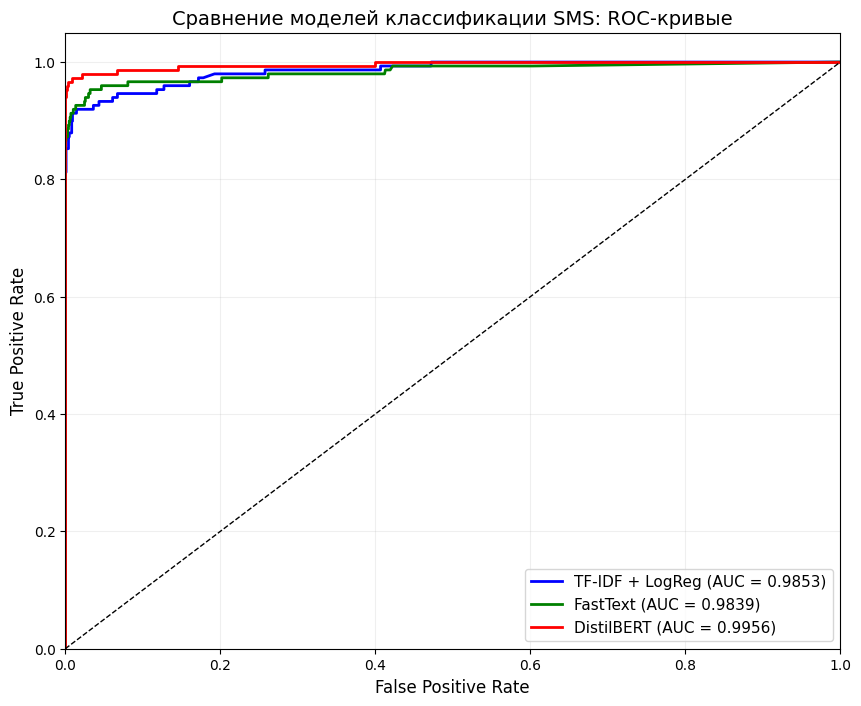

In [93]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

def get_metrics(y_true, y_pred, y_prob, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_prob)
    return {
        'Model': model_name,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'ROC-AUC': round(roc_auc, 4)
    }

results = [
    get_metrics(y_test, y_pred_lr, y_prob_lr, 'TF-IDF + LogReg'),
    get_metrics(y_test, y_pred_ft, y_prob_ft, 'FastText'),
    get_metrics(y_test, y_pred_bert, y_prob_bert, 'DistilBERT')
]

results_df = pd.DataFrame(results)
print(results_df)

# 1. Расчет кривых
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_ft, tpr_ft, _ = roc_curve(y_test, y_prob_ft)
roc_auc_ft = auc(fpr_ft, tpr_ft)

fpr_bert, tpr_bert, _ = roc_curve(y_test, y_prob_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# 2. Построение графика
plt.figure(figsize=(10, 8))



plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label=f'TF-IDF + LogReg (AUC = {roc_auc_lr:.4f})')

plt.plot(fpr_ft, tpr_ft, color='green', lw=2, 
         label=f'FastText (AUC = {roc_auc_ft:.4f})')

plt.plot(fpr_bert, tpr_bert, color='red', lw=2, 
         label=f'DistilBERT (AUC = {roc_auc_bert:.4f})')

# Оформление
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Сравнение моделей классификации SMS: ROC-кривые', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.2)
plt.show()

### Заключение
Модель BERT выдала великолепные показатели метрик — все значения приближаются к 1, но при построении матрицы ошибок выяснилось, что, в отличие от предыдущих моделей, количество ложноположительных результатов (то есть определенных в категорию "spam" SMS сообщений) не равно нулю. Учитывая специфику задачи, можно заключить, что BERT в данном случае не лучший выбор. К тому же время обучения модели (1338.39 сек) и требовательность к ресурсам также говорят не в ее пользу.
Исходя из результатов исследования, для инференса выбрана модель FastText. Эта модель не имеет ложноположительных предсказаний, то есть она не делает критических ошибок — не относит к спаму нормальные сообщения.

## Сохранение модели

Для того, чтобы использовать обученную модель в дальнейшем, необходимо ее сохранить.

In [17]:
ft_model.save_model("fasttext_spam_model.bin")